In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from datetime import datetime
from tqdm import tqdm
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2    
from tensorflow.keras.layers import Conv3D, Conv2D, MaxPooling3D, Dropout, ConvLSTM2D, Softmax, Lambda, UpSampling2D, MaxPooling2D, TimeDistributed, Input
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, Conv3DTranspose, Conv2DTranspose, UpSampling3D, Concatenate, LayerNormalization, ReLU, Add, Multiply
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.backend import clear_session
import glob
import sys

2025-03-25 16:03:09.294240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-25 16:03:09.530468: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 16:03:10.117440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dministrator/miniconda3/envs/tf/lib/
2025-03-25 16:03:10.118026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer

In [2]:
clear_session()

In [3]:
# Check if TensorFlow is built with GPU support
print("Built with GPU support:", tf.test.is_built_with_cuda())

# List available physical devices (CPU/GPU)
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Number of GPUs available: {len(physical_devices)}")
    for i, gpu in enumerate(physical_devices):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU available.")

Built with GPU support: True
Number of GPUs available: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2025-03-25 16:03:11.358220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 16:03:11.448371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 16:03:11.448405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Loss definitions

In [4]:
# taken from https://github.com/nabsabraham/focal-unet/blob/master/losses.py


epsilon = 1e-5
smooth = 1


def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)
        loss = -y_true * alpha * tf.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.mean(loss)
    return loss


def dsc(y_true, y_pred):
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')
    smooth = 1.
    axis = (1,2,3,4)
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    y_true_f = tf.reduce_sum(y_true, axis=axis)
    y_pred_f = tf.reduce_sum(y_pred, axis=axis)

    intersection = tf.reduce_sum(y_true * y_pred)

    #score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    score = (2. * intersection + smooth) / (y_true_f + y_pred_f + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.8*binary_crossentropy(y_true, y_pred) + 0.2*dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    # Ensure both y_true and y_pred are of the same type (float32)
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')



    
    
    axis = (1,2,3,4)
    P_foreground = y_pred[:,:,:,:,:1]
    P_background = y_pred[:,:,:,:,1:]
    g_foreground = y_true[:,:,:,:,:1]
    g_background = y_true[:,:,:,:,1:]

    #y_true_pos = K.flatten(y_true)
    #y_pred_pos = K.flatten(y_pred)
    true_pos = P_foreground * g_foreground
    true_pos = tf.reduce_sum(true_pos, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5*tf.reduce_sum(false_neg, axis=axis)

    #true_pos = K.sum(y_true_pos * y_pred_pos)
    #false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    #false_pos = K.sum((1 - y_true_pos) * y_pred_pos)

    alpha = 0.8
    smooth = 1e-6

    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 1.33 # 0.75
    return tf.pow((1-pt_1), gamma)

def IoU(y_true, y_pred, dtype=tf.float32):
    y_pred = tf.cast(y_pred, dtype)
    y_true = tf.cast(y_true, y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)

    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))
    
    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect
    
    # Return the IoU score
    return tf.math.divide_no_nan(area_intersect, area_union)

## Utilities

In [5]:
def Conv3DBlock(
    inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn="relu"
):
    """
    Builds the 3d conv block
    Apply successivly a 3D convolution, BatchNormalization and relu
    """
    # Skip pointwise by setting num_outputs=Non
    net = Conv3D(
        filters=n_filters,
        kernel_size=kernel_size,
        strides=stride,
        padding="same",
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
    )(inputs)
    net = BatchNormalization()(net)
    #net = LayerNormalization()(net)
    net = Activation(activation_fn)(net)

    return net

def Conv3DBlockTranspose(
    inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn="relu"
):
    """
    Builds the 3d conv transpose block
    Apply successivly a 3D transpose convolution, BatchNormalization and relu
    """
    # Skip pointwise by setting num_outputs=Non
    net = Conv3DTranspose(
        filters=n_filters,
        kernel_size=kernel_size,
        strides=stride,
        padding="same",
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
    )(inputs)
    net = BatchNormalization()(net)
    #net = LayerNormalization()(net)
    net = Activation(activation_fn)(net)

    return net



def AtrousSpatialPyramidPoolingModule_3D(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)
    
    image_features = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )


    atrous_pool_block_1 = Conv3D(depth, (1, 1, 1), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None)(inputs)

    atrous_pool_block_6 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(12, 12, 12), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(18, 18, 18), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net



def AtrousSpatialPyramidPoolingModule_3D_rate_9(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)

    image_features = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )

    atrous_pool_block_1 = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(inputs)

    atrous_pool_block_6 = Conv3D(
        depth,
        (1, 1, 1),
        dilation_rate=(2, 2, 2),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(4, 4, 4), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net

def AtrousSpatialPyramidPoolingModule_3D_rate_11(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)

    image_features = Conv3D(depth, (1, 1, 1),kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None)(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )

    atrous_pool_block_1 = Conv3D(depth, (1, 1, 1), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None)(inputs)

    atrous_pool_block_6 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(4, 4, 4), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(8, 8, 8), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net



def AttentionRefinementModule_3D(inputs, n_filters):
    "for 3d data"
    # 3D Global average pooling
    net = tf.reduce_mean(inputs, axis=[2, 3], keepdims=True)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)

    #net = LayerNormalization()(net)
    net = BatchNormalization()(net)
    net = tf.sigmoid(net)
    net = tf.multiply(inputs, net)

    return net

def FeatureFusionModule(input_1, input_2, n_filters):

    #inputs = Concatenate()([input_1, input_2])
    inputs = Concatenate(axis=-1)([input_1, input_2])

    inputs = Conv3DBlock(
        inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn=None
    )

    # Global average pooling
    net = Lambda(lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True))(inputs)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    net = ReLU()(net)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    
    net = Lambda(lambda x: tf.sigmoid(x))(net)

    net = Multiply()([inputs, net])
    net = Add()([inputs, net])

    return net

def FeatureFusionModule_with_Stirde(input_1, input_2, n_filters):

    #inputs = tf.concat([input_1, input_2], axis=-1)
    inputs = Concatenate(axis=-1)([input_1, input_2])

    inputs = Conv3DBlock(
        inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 2, 2], activation_fn=None
    )

    # Global average pooling
    #net = tf.reduce_mean(inputs, axis=[2, 3], keepdims=True)
    net = Lambda(lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True))(inputs)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    net = ReLU()(net)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    
    #net = tf.sigmoid(net)
    net = Lambda(lambda x: tf.sigmoid(x))(net)
    
    net = Multiply()([inputs, net])
    net = Add()([inputs, net])

    return net



def Tversky_Index(prediction, ground_truth, axis=(1, 2, 3, 4)):
    """
    prediction is the probabilities from softmax, here it act as Dice Coef, as alpha and beta
    """
    smooth = 1
    P_foreground = prediction[..., :1]
    P_background = prediction[..., 1:]
    g_foreground = ground_truth[..., :1]
    g_background = ground_truth[..., 1:]

    true_positive = P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = 0.5 * tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5 * tf.reduce_sum(false_neg, axis=axis)

    Tversky = tf.divide(
        true_positive + smooth, (true_positive + false_pos + false_neg + smooth)
    )

    return tf.reduce_mean(Tversky)

def dice_coe(output, target, loss_type="sorensen", axis=(1, 2, 3, 4), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity"""
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == "jaccard":
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == "sorensen":
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # new haodong
    dice = (2.0 * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name="dice_coe")
    return dice


def iou_coe(output, target, threshold=0.5, axis=(1, 2, 3, 4), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the similarity"""
    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(
        tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis
    )  # OR

    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, name="iou_coe")
    return iou  # , pre, truth, inse, union


def dice_hard_coe(output, target, threshold=0.5, axis=(1, 2, 3, 4), smooth=1e-5):
    """Non-differentiable Sørensen–Dice coefficient for comparing the similarity"""
    output = tf.cast(output > threshold, dtype=tf.float32)
    target = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(output, target), axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)
    hard_dice = (2.0 * inse + smooth) / (l + r + smooth)
    ##
    hard_dice = tf.reduce_mean(hard_dice, name="hard_dice")
    return hard_dice

def confusion(y_true, y_pred):
    smooth = 1

    y_pred_pos = tf.clip_by_value(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos

    y_pos = tf.clip_by_value(y_true, 0, 1)
    y_neg = 1 - y_pos

    tp = tf.reduce_sum(y_pos * y_pred_pos)
    fp = tf.reduce_sum(y_neg * y_pred_pos)
    fn = tf.reduce_sum(y_pos * y_pred_neg)


    prec = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)

    return prec, recall

def Downsampling_2D(inputs, scale1, scale2):
    return tf.image.resize(
        inputs, size=[scale1, scale2], method=tf.image.ResizeMethod.BILINEAR
    )


def Down_sample_3D(input_layer, scale1, scale2):
    """
    TODO : 10 should be changed to new time scale 10 30 or 200
    """
    unpol_layer = tf.map_fn(
        lambda layer: Downsampling_2D(layer, scale1, scale2),
        input_layer,
        dtype=tf.float32,
    )

    return tf.transpose(tf.stack(unpol_layer), [1, 0, 2, 3, 4])

def skip(layer, end_point):
    return tf.concat([layer, end_point], axis=4)  # -1


def unpool(layer):
    height = layer.shape[1] * 2
    width = layer.shape[2] * 2
    return tf.image.resize(
        layer, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )


def unpool_3D_2(input_layer):

    unpol_layer = tf.map_fn(lambda layer: unpool(layer), input_layer, dtype=tf.float32)
    return tf.transpose(tf.stack(unpol_layer), [1, 0, 2, 3, 4])


def unpool_3D(input_layer):

    unpol_layer = tf.keras.layers.UpSampling3D(size=(1, 2, 2))(input_layer)
    return unpol_layer

def unpool_2D(input_layer):
    """
    2D Unpooling using UpSampling2D.

    Parameters:
    - input_layer: Tensor, feature map to be upsampled.

    Returns:
    - unpol_layer: Tensor, upsampled feature map.
    """
    unpol_layer = tf.keras.layers.UpSampling2D(size=(2, 2))(input_layer)
    return unpol_layer


# Re-define for 5D Tensor, here we are dealing with 5D: axis=3 become axis=4 last channel
def pixel_wise_softmax(output_map):
    return layers.Softmax(axis=-1, name="softmax_output")(output_map)


def weight_variable(shape):

    weights_initializer = tf.keras.initializers.VarianceScaling(
        scale=1.0,
        mode="fan_avg",
        distribution="uniform" if True else "truncated_normal",
        seed=None,
        dtype=tf.float32,
    )
    Weight = tf.Variable(weights_initializer(shape=shape))

    return Weight



def iou_coe_Slice_by_Slice(output, target, threshold=0.5, axis=(2, 3, 4), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the similarity"""

    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)

    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)

    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, axis=0, name="iou_coe")

    return iou  # , pre, truth, inse, union


def Tversky_Index_Slice_by_Slice(prediction, ground_truth, axis=(2, 3, 4)):
    """
    prediction is the probabilities from softmax, here it act as Dice Coef, as alpha and beta
    """
    smooth = 1
    P_foreground = prediction[..., :1]
    P_background = prediction[..., 1:]
    g_foreground = ground_truth[..., :1]
    g_background = ground_truth[..., 1:]

    true_positive = P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = 0.5 * tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5 * tf.reduce_sum(false_neg, axis=axis)

    Tversky = tf.divide(
        true_positive + smooth, (true_positive + false_pos + false_neg + smooth)
    )

    return tf.reduce_mean(Tversky, axis=0)


# Hausdorff Distance
def HausdorffDist(A, B):

    A_squared = np.sum(A**2, axis=1, keepdims=True)
    B_squared = np.sum(B**2, axis=1, keepdims=True)
    D_mat = np.sqrt(A_squared - 2 * np.dot(A, B.T) + B_squared.T)

    # Find DH
    max_dist_A_to_B = np.max(np.min(D_mat, axis=1))
    max_dist_B_to_A = np.max(np.min(D_mat, axis=0))
    dH = np.max([max_dist_A_to_B, max_dist_B_to_A])

    return dH


def ComputeHDD(A, B):
    """A and B has the following Shape
    tensor of 3d: batch, H, W
    """
    return list(map(lambda a, b: HausdorffDist(a, b), A, B))


def process_data_with_spacing(data_file_path):
    """
    Return 3 masks in order SOL, GL and GM.
    Input: main path for the dataset: either Train/Val/or Testm i.e. '/tf/volumes/train/CAT_TH/masksX1.mha'
    """

    # Read the data of formate (528, 640, 1574)
    image_data, HEADER = load(data_file_path)
    # Adjust the formate to (640, 528, 1574)
    image_data = image_data.transpose([1, 0, 2])

    image_data = list(
        map(
            lambda mask_time_step: crop_pad(mask_time_step),
            image_data.transpose(2, 0, 1),
        )
    )  # ,(512,640),

    return np.array(image_data), HEADER.spacing



## Definition of IFSS neural network without masks

In [6]:
# Define the IFSS neural network withou masks
def create_model(input_shape, keep_prob_skip=0.2):   
    x_target = tf.keras.Input(shape=input_shape, name='x_target')  # Only input frames

    ################# Layer 1
    Layer_1 = Conv3DBlock(x_target, n_filters=30, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_1p')(Layer_1)
    Layer_1 = AtrousSpatialPyramidPoolingModule_3D(Layer_1, depth=6)
    Layer_1 = Dropout(rate=1 - keep_prob_skip)(Layer_1)

    ################ Layer 2
    Layer_2 = Conv3DBlock(Layer_1, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_2 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_2p')(Layer_2)
    Layer_2 = AtrousSpatialPyramidPoolingModule_3D(Layer_2, depth=6)
    Layer_2 = Dropout(rate=1 - keep_prob_skip)(Layer_2)

    ############### Layer 3
    Layer_3 = Conv3DBlock(Layer_2, 60, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_3 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_3p')(Layer_3)
    Layer_3 = AtrousSpatialPyramidPoolingModule_3D_rate_11(Layer_3, depth=12)
    Layer_3 = Dropout(rate=1 - keep_prob_skip)(Layer_3)
    
    ############## Layer 4
    Layer_4 = Conv3DBlock(Layer_3, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_4 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_4p')(Layer_4)
    Layer_4 = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_4, depth=24)
    Layer_4 = Dropout(rate=1 - keep_prob_skip)(Layer_4)

    ############## Layer 5
    Layer_5 = Conv3DBlock(Layer_4, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_5 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_5p')(Layer_5)
    Layer_5 = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_5, depth=24)

    # Apply Bi-ConvLSTM for SpatioTemporal Correlations
    BiSpatioTemporal_x_y_F = ConvLSTM2D(filters=120, kernel_size=(1, 1), padding='same', return_sequences=True, 
                                        go_backwards=False, kernel_initializer='he_normal',
                                        recurrent_dropout=0.3, activation=tf.nn.tanh)(Layer_5)

    BiSpatioTemporal_x_y_B = ConvLSTM2D(filters=120, kernel_size=(1, 1), padding='same', return_sequences=True, 
                                        go_backwards=True, kernel_initializer='he_normal',
                                        recurrent_dropout=0.3, activation=tf.nn.tanh)(Layer_5)

    # Combine forward and backward passes
    BiSpatioTemporal_x_y = tf.keras.layers.Add()([BiSpatioTemporal_x_y_F, BiSpatioTemporal_x_y_B])
    
    
    ########## Layer 6
    Layer_6 = Conv3DBlockTranspose(BiSpatioTemporal_x_y, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_6 = Conv3DBlock(Layer_6, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_6 = FeatureFusionModule(input_1=Layer_6, input_2=BiSpatioTemporal_x_y, n_filters=120)
    Layer_6 = unpool_3D(Layer_6)
    Layer_6 = Dropout(1 - keep_prob_skip)(Layer_6)
    #print(Layer_6)
    
    ######### Layer 7
    Layer_7 = Conv3DBlockTranspose(Layer_6, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_7 = Conv3DBlock(Layer_7, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_7 = FeatureFusionModule(input_1=Layer_7, input_2=Layer_4, n_filters=120)
    Layer_7 = unpool_3D(Layer_7)
    Layer_7 = Dropout(1 - keep_prob_skip)(Layer_7)
    #print(Layer_7)
    
    ######### Layer 8
    Layer_8 = Conv3DBlockTranspose(Layer_7, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_8 = Conv3DBlock(Layer_8, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_8 = FeatureFusionModule(input_1=Layer_8, input_2=Layer_3, n_filters=60)
    Layer_8 = unpool_3D(Layer_8)
    Layer_8 = Dropout(1 - keep_prob_skip)(Layer_8)
    #print(Layer_8)
        
    ######## Layer 9
    Layer_9 = Conv3DBlockTranspose(Layer_8, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_9 = Conv3DBlock(Layer_9, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_9 = FeatureFusionModule(input_1=Layer_9, input_2=Layer_2, n_filters=60)
    Layer_9 = unpool_3D(Layer_9)
    Layer_9 = Dropout(1 - keep_prob_skip)(Layer_9)
    #print(Layer_9)
    
    ######## Layer 10
    Layer_10 = Conv3DBlockTranspose(Layer_9, 16, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_10 = Conv3DBlock(Layer_10, 16, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_10 = FeatureFusionModule(input_1=Layer_10, input_2=Layer_1, n_filters=16)
    Layer_10 = unpool_3D(Layer_10)
    Layer_10 = Dropout(1 - keep_prob_skip)(Layer_10)
    #print(Layer_10)
    
    ######## Layer 11
    Layer_11 = Conv3DBlockTranspose(Layer_10, 8, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_11 = Conv3DBlock(Layer_11, 8, kernel_size=[1,1,1], stride=[1,1,1], activation_fn=None)
    Layer_11 = Dropout(1 - keep_prob_skip)(Layer_11)  
    #print(Layer_11)     

    # Final Output
    net_output_256_logits = Conv3D(num_classes, kernel_size=(1,1,1), activation=tf.nn.relu, 
                                   padding="same", kernel_initializer=GlorotUniform(),
                                   kernel_regularizer=l2(1e-4))(Layer_11)
    
    output = pixel_wise_softmax(net_output_256_logits)

    model = Model(inputs=x_target, outputs=output)
    return model

# Model dimensions
time_step = None  # Keep it flexible
H, W, C = 512, 512, 1
num_classes = 2  

input_shape_x = (time_step, H, W, C)

# Model creation
model = create_model(input_shape_x)

# Model compilation
model.compile()

# Check model summary
model.summary()
print(model.output_shape)


2025-03-25 16:03:11.552554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-25 16:03:11.555201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 16:03:11.555238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 16:03:11.555249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_target (InputLayer)          [(None, None, 512,   0           []                               
                                512, 1)]                                                          
                                                                                                  
 conv3d (Conv3D)                (None, None, 512, 5  840         ['x_target[0][0]']               
                                12, 30)                                                           
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 512, 5  120        ['conv3d[0][0]']                 
 alization)                     12, 30)                                                       

## Load training data

In [7]:
import cv2
# Define directories for masks and videos
mask_directory = '../data/analyzed_copy/mask/Patient5/MZP1'
video_directory = '../data/analyzed_copy/volume/Patient5/MZP1'

sub_vol_size = 3
last_ind = sub_vol_size-1

# Loading the masks
mask_dataset = []
mask_number_all = []
m_dataset = []

for path in glob.glob(os.path.join(mask_directory, "video*")):

    frame_mask_dataset = []
    mask_number = []

    for mask_path in glob.glob(os.path.join(path, "*.tif")):

        filename = os.path.splitext(os.path.basename(mask_path))[0]
        number = filename.split('_')[-1]
        number = int(number)
        mask_number.append(number)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (512, 512))
        mask = cv2.dilate(mask, np.ones((2,2), np.uint8), iterations=1)
        #mask = np.stack((mask, mask), axis=-1)
        mask = np.clip(np.where(mask>1, mask, 0), 0, 1)
        mask = np.expand_dims(mask, -1)
        mask = np.concatenate([mask, 1-mask], -1)
        mask = np.array(mask)
        # mask = mask/255.0
        frame_mask_dataset.append(mask) 

    frame_mask_dataset = np.array(frame_mask_dataset)
    mask_dataset.append(frame_mask_dataset)
    mask_number_all.append(mask_number)

    stacked_masks_set = []

    # Used for fully supervised learning, comment stacked_masks_set and m_dataset for weakly supervised learning
    # Stack the frames to create a set of 3 frames
    stacked_masks_set = np.array([np.stack([frame_mask_dataset[i], frame_mask_dataset[i+1], frame_mask_dataset[i+2]], axis=0)
                               for i in range(len(frame_mask_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    m_dataset.append(stacked_masks_set)

# Loading and stacking the image frames
image_dataset = []
video_length = []

for path in glob.glob(os.path.join(video_directory, "video*")):
    
    frame_dataset = []

    for frame_path in glob.glob(os.path.join(path, "*.tif")):

        frame = cv2.imread(frame_path, 1)
        frame = cv2.resize(frame, (512,512))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
        frame = np.array(frame)/255.0
        frame_dataset.append(frame)

    frame_dataset = np.array(frame_dataset)
    single_video_length = len(frame_dataset)
    video_length.append(single_video_length)
    
    # Stack the frames to create a set of 3 frames
    stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
                               for i in range(len(frame_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    image_dataset.append(stacked_frames_set)

# Weakling supervised learning
# Handling masks with missig data
#mask_dataset_complete = []
    
#for i in range(len(mask_number_all)):

    #target_length = video_length[i]
    #target_array = np.empty(target_length, dtype=object)
    #target_mask_set = mask_dataset[i]

    #for j in range(len(mask_number_all[i])):
        #target_array[mask_number_all[i][j]] = target_mask_set[j]
       
    #mask_dataset_complete.append(target_array)

#mask_dataset_complete = np.array(mask_dataset_complete, dtype=object)

# Fully supervised learning
x_train = image_dataset
y_train = m_dataset

# Weakly supervised learning
#x_train = np.array(image_dataset, dtype=object)
#y_train = mask_dataset_complete



(512, 512, 1)
(512, 512)


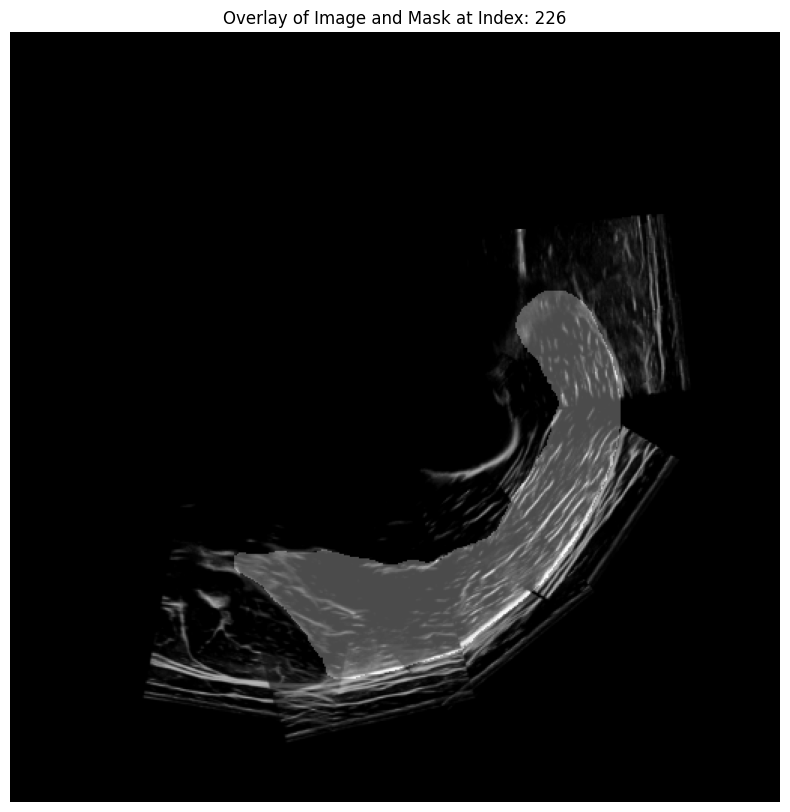

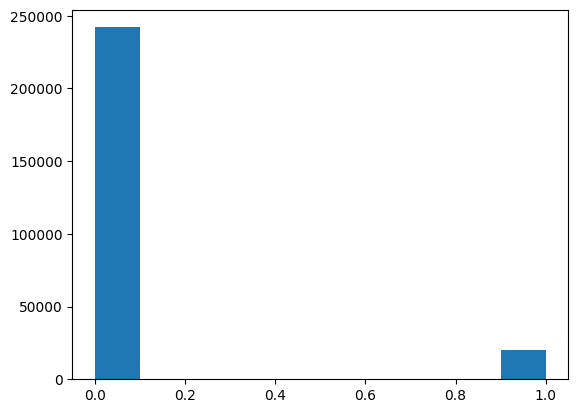

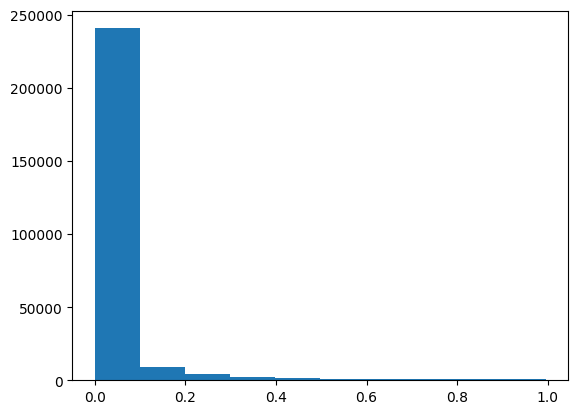

In [8]:
import random
# Function to plot a random image with its corresponding mask overlay
def plot_random_image_with_mask_overlay(x_train, y_train):
    # Flatten the list of all images and masks for easy random selection
    all_images = [frame for video in x_train for frame in video]
    all_masks = [mask for video in y_train for mask in video if mask is not None]
    
    # Select a random index
    random_index = random.randint(0, min(len(all_images), len(all_masks)) - 1)
    
    # Retrieve the corresponding image and mask
    random_image = all_images[random_index][1]  # Select the middle frame from the stack
    random_mask = all_masks[random_index][..., 0][0]  # Assume a single channel mask
    
    # Plot the image with its mask overlay
    plt.figure(figsize=(10, 10))
    plt.title(f"Overlay of Image and Mask at Index: {random_index}")
    
    # Display the image
    plt.imshow(random_image, cmap='gray')
    print(random_image.shape)
    
    # Overlay the mask with some transparency
    plt.imshow(random_mask, cmap='gray', alpha=0.3)  # 'jet' colormap highlights the mask
    print(random_mask.shape)   
      

    plt.axis('off')
    plt.show()
    plt.hist(random_mask.flatten())
    plt.show()
    
    plt.hist(random_image.flatten())
    plt.show()

# Call the function to plot an image with its mask overlay
plot_random_image_with_mask_overlay(x_train, y_train)




## Load Validation Data

In [9]:
# Define directories for masks and videos
mask_directory = '../data/val/mask/'
video_directory = '../data/val/volume/'

sub_vol_size = 3
last_ind = sub_vol_size-1

# Loading the masks
mask_dataset = []
m_dataset = []
mask_number_all = []

for path in glob.glob(os.path.join(mask_directory, "video*")):

    frame_mask_dataset = []
    mask_number = []

    for mask_path in glob.glob(os.path.join(path, "*.tif")):

        filename = os.path.splitext(os.path.basename(mask_path))[0]
        number = filename.split('_')[-1]
        number = int(number)
        mask_number.append(number)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (512,512))
        mask = cv2.dilate(mask, np.ones((2,2), np.uint8), iterations=1)
        #mask = np.stack((mask, mask), axis=-1)
        mask = np.clip(np.where(mask>1, mask, 0), 0, 1)
        mask = np.expand_dims(mask, -1)
        mask = np.concatenate([mask, 1-mask], -1)
        mask = np.array(mask)
        # mask = mask/255.0
        frame_mask_dataset.append(mask) 

    frame_mask_dataset = np.array(frame_mask_dataset)
    mask_dataset.append(frame_mask_dataset)
    mask_number_all.append(mask_number)

    stacked_masks_set = []

    # Used for fully supervised learning, comment stacked_masks_set and m_dataset for weakly supervised learning
    # Stack the frames to create a set of 3 frames
    stacked_masks_set = np.array([np.stack([frame_mask_dataset[i], frame_mask_dataset[i+1], frame_mask_dataset[i+2]], axis=0)
                               for i in range(len(frame_mask_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    m_dataset.append(stacked_masks_set)

# Loading and stacking the image frames
image_dataset = []
video_length = []

for path in glob.glob(os.path.join(video_directory, "video*")):

    frame_dataset = []

    for frame_path in glob.glob(os.path.join(path, "*.tif")):

        frame = cv2.imread(frame_path, 1)
        frame = cv2.resize(frame, (512,512))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
        frame = np.array(frame)/255.0
        frame_dataset.append(frame)

    frame_dataset = np.array(frame_dataset)
    single_video_length = len(frame_dataset)
    video_length.append(single_video_length)

    stacked_frames_set = []

     # Stack the frames to create a set of 3 frames
    stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
                               for i in range(len(frame_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    image_dataset.append(stacked_frames_set)

# Weakly supervised training
# Handling masks with missing data
#mask_dataset_complete = []
    
#for i in range(len(mask_number_all)):

    #target_length = video_length[i]
    #target_array = np.empty(target_length, dtype=object)
    #target_mask_set = mask_dataset[i]

    #for j in range(len(mask_number_all[i])):
        #target_array[mask_number_all[i][j]] = target_mask_set[j]

    #mask_dataset_complete.append(target_array)

#mask_dataset_complete = np.array(mask_dataset_complete, dtype=object)

# Fully supervised training
x_val = image_dataset
y_val = m_dataset
# Weakly supervised training
#x_val = np.array(image_dataset, dtype=object)
#y_val = mask_dataset_complete


## Plot Masks during training

In [10]:
import matplotlib.pyplot as plt
import os

def plot_batch_with_masks(x_batch, y_true_batch, output_masks, save_dir='batch_plots', epoch=None):
    """
    Plots the 2nd frame (index 1) from the 1st batch with its ground truth and predicted mask.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # ✅ Select 2nd image (index 1) from first batch
    batches = len(x_batch[-1])
    print(f"Number of batches: {batches}")
    x_image = x_batch[-1]          # Shape: (time, H, W, C)
    y_true = y_true_batch[-1]
    y_pred = output_masks[0]

    # ✅ Select the 2nd frame (index 1) and squeeze
    x_image_selected = x_image[batches-1, 1, ..., 0]
    x_image_selected = np.squeeze(x_image_selected)        # Shape: (H, W)
    y_true_selected = y_true[batches-1, 1, ..., 0]          # Shape: (H, W)
    y_true_selected = np.squeeze(y_true_selected)        # Shape: (H, W)
    y_pred_selected = y_pred[1, ..., 0]          # Shape: (H, W)
    

    # ✅ Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(x_image_selected, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(y_true_selected, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(y_pred_selected, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    # ✅ Save
    title = f"Epoch {epoch+1}" if epoch is not None else "Prediction"
    fig.suptitle(title)
    filename = f"epoch_{epoch+1}_frame_2.png" if epoch is not None else "frame_2.png"
    plt.savefig(os.path.join(save_dir, filename))
    plt.close()


## Training loop

In [11]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [12]:
import datetime

# TensorBoard log directory
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = tf.summary.create_file_writer(log_dir)


In [13]:
# Variable definitions
#loss_object = tf.keras.losses.binary_crossentropy

optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.Accuracy()
val_acc_metric = tf.keras.metrics.Accuracy()
train_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2, axis=(1, 2, 3, 4))
val_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2, axis=(1, 2, 3, 4))

epochs = 200

# Define ModelCheckpoint class
class ModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=0, save_best_only=False, mode='min'):
        super(ModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best = np.Inf if mode == 'min' else -np.Inf
        self.mode = mode

        if mode not in ['auto', 'min', 'max']:
            print(f"ModelCheckpoint mode {mode} is unknown, fallback to auto mode.")
            self.mode = 'auto'

        if self.mode == 'min':
            self.monitor_op = np.less
        elif self.mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            print(f"Warning: Monitor value {self.monitor} is not available in logs. Skipping checkpoint saving.")
            return
        
        filepath = self.filepath.format(epoch=epoch)

        if self.save_best_only:
            if self.monitor_op(current, self.best):
                if self.verbose > 0:
                    print(f"\nEpoch {epoch}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {filepath}")
                self.best = current
                self.model.save(filepath)
            else:
                if self.verbose > 0:
                    print(f"\nEpoch {epoch}: {self.monitor} did not improve from {self.best:.5f}")
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch}: saving model to {filepath}")
            self.model.save(filepath)

# Define CSVLogger class
class CSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, filename, separator=',', append=False):
        super(CSVLogger, self).__init__()
        self.filename = filename
        self.sep = separator
        self.append = append
        self.keys = None
        self.append_header = not append or not os.path.exists(filename)
        self.file_flags = 'a' if append else 'w'
        
    def on_train_begin(self, logs=None):
        self.csv_file = open(self.filename, self.file_flags, newline='')
        self.writer = csv.writer(self.csv_file, delimiter=self.sep)
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if self.keys is None:
            self.keys = sorted(logs.keys())
            if self.append_header:
                self.writer.writerow(['epoch'] + self.keys)
                
        row = [epoch] + [logs[k] for k in self.keys]
        self.writer.writerow(row)
        self.csv_file.flush()
        
    def on_train_end(self, logs=None):
        self.csv_file.close()

# Define EarlyStoppingCallback class
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, min_delta=0, patience=0):
        super().__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.best = float('inf')
        self.wait = 0
        self.stopped_epoch = 0
        

    def on_epoch_end(self, epoch, logs):
        current = logs.get('val_loss')
        if current is None:
            return
        
        # Update the best validation loss
        if current < self.best - self.min_delta:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if hasattr(self.model, 'stop_training'):
                    self.model.stop_training = True
                print(f"Epoch {epoch}: early stopping")
                return
    
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Training stopped early at epoch {self.stopped_epoch}")

# Define ReduceLROnPlateauCallback class
class ReduceLROnPlateauCallback(tf.keras.callbacks.Callback):
    def __init__(self, factor=0.1, min_lr=0.0000001, patience=4, threshold=0.0001):
        super().__init__()
        self.factor = factor
        self.min_lr = min_lr
        self.patience = patience
        self.threshold = threshold
        self.wait = 0
        self.best = float('inf')
    
    def on_epoch_end(self, epoch, logs):
        current = logs.get('val_loss')
        if current is None:
            return 
    
        current_lr = optimizer.learning_rate.numpy()

        # initialize or update the best validation loss
        if current < self.best - self.threshold:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # reduce the learning rate
                new_lr = max(current_lr * self.factor, self.min_lr)
                optimizer.learning_rate.assign(new_lr)
                print(f"Epoch {epoch}: reducing learning rate to {new_lr:.6f}")
                self.wait = 0

# Define functions to validate data
@tf.function
def val_step(x_val, y_val):
    print(x_val.shape)
    output_masks = model(x_val, training=False)
    output_masks = tf.clip_by_value(output_masks, 0, 1)
    val_loss = focal_tversky(y_val, output_masks)

    dice_sim_coeff = dsc(y_val, output_masks)

    val_acc_metric.update_state(y_val, output_masks)
    val_iou_metric.update_state(y_val, output_masks)

    return val_loss, dice_sim_coeff, output_masks

def val_model(x_val, y_val):
    total_val_loss = []
    total_dice_sim_coeff = []

    for batch_idx in range(len(x_val)):
        x_batch = x_val[batch_idx]
        y_batch = y_val[batch_idx]

        for step in range(len(x_batch)):
            x_images = x_batch[step]
            x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))

            y_masks = y_batch[step]
            y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))
            
            val_loss, dice_sim_coeff, output_masks = val_step(x_images, y_masks)
            output_masks = tf.clip_by_value(output_masks, 0, 1)

            total_val_loss.append(val_loss)
            total_dice_sim_coeff.append(dice_sim_coeff)

    val_acc = val_acc_metric.result()
    val_iou = val_iou_metric.result()
    print(f"Accuracy over Validation Set: {val_acc} | IoU over Validation Set: {val_iou} | Dice Similarity Coefficient: {np.mean(total_dice_sim_coeff)}")
    val_acc_metric.reset_state()
    val_iou_metric.reset_state()

    return np.mean(total_val_loss), np.mean(total_dice_sim_coeff), val_iou, output_masks

# ✅ Updated Training Step (Only Uses `x_target` Now)
@tf.function
def train_step(x_train_batch, y_train_batch):
    with tf.GradientTape() as tape:
        output_masks = model(x_train_batch, training=True)
        output_masks = tf.clip_by_value(output_masks, 0, 1)  # Clip the output values
        loss = focal_tversky(y_train_batch, output_masks)
        dice_sim_coeff = dsc(y_train_batch, output_masks)

    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    train_acc_metric.update_state(y_train_batch, output_masks)
    train_iou_metric.update_state(y_train_batch, output_masks)

    return loss, output_masks, dice_sim_coeff

# ✅ Updated Training Loop (Using Stacked Frames)
def train_model(x_train, y_train, x_val, y_val, epochs):
    early_stopping = EarlyStoppingCallback(patience=10)
    reduce_lr = ReduceLROnPlateauCallback(factor=0.1, min_lr=0.0000001, patience=5)

    checkpoint_callback = ModelCheckpoint(filepath='IFSS_checkpoint_epoch{epoch:02d}.weights.h5', monitor='val_loss', save_best_only=True, verbose=1)
    checkpoint_callback.set_model(model)

    csv_logger = CSVLogger(filename='training_log.csv', separator=',', append=False)
    csv_logger.on_train_begin()

    total_batches = sum(len(batch) for batch in x_train)  # Total number of batches across steps

    for epoch in range(epochs):
        print(f"Start of training epoch: {epoch}")

        total_loss = []
        total_dice = []

        # Create a progress bar for the current epoch with the total number of batches
        with tqdm(total=total_batches, desc=f"Epoch {epoch+1}/{epochs} ({total_batches} batches)", unit="batch") as pbar:
            for batch_idx in range(len(x_train)):
                x_batch = x_train[batch_idx]
                y_batch = y_train[batch_idx]

                for step in range(len(x_batch)):
                    x_images = x_batch[step]
                    x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))
                    y_masks = y_batch[step]
                    y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))

                    loss, output_masks, train_dice = train_step(x_images, y_masks)
                    output_masks = tf.clip_by_value(output_masks, 0, 1)
                    total_loss.append(loss)
                    total_dice.append(train_dice)

                    pbar.update(1)

        # Calculate metrics for the current epoch
        train_acc = train_acc_metric.result()
        train_iou = train_iou_metric.result()
        print(f"Accuracy over epoch {epoch}: {train_acc} | IoU over epoch {epoch}: {train_iou} | Dice Similarity Coefficient: {np.mean(total_dice)}")
        train_acc_metric.reset_state()
        train_iou_metric.reset_state()

        print(f'Epoch {epoch}, Loss: {np.mean(total_loss)}')

        # Validate
        val_loss_epoch, dice_sim_coeff_epoch, val_iou_epoch, output_masks_val = val_model(x_val, y_val)

        logs = {'val_loss': np.array(val_loss_epoch), 
                'accuracy': train_acc.numpy(), 
                'iou': train_iou.numpy(), 
                'tversky_loss': np.mean(total_loss),
                'train_dice_similarity_coefficient': np.mean(train_dice),
                'val_dice_similarity_coefficient': np.array(dice_sim_coeff_epoch),
                }
        
         # tensoroard callbacks
        with writer.as_default():
            tf.summary.scalar('Loss/Train', np.mean(total_loss), step=epoch)
            tf.summary.scalar('Loss/Validation', val_loss_epoch, step=epoch)
            tf.summary.scalar('DiceCoeff/Train', np.mean(total_dice), step=epoch)
            tf.summary.scalar('IoU/Train', train_iou, step=epoch)
            tf.summary.scalar('IoU/Validation', val_iou_epoch, step=epoch)
            tf.summary.scalar('DiceCoeff/Validation', dice_sim_coeff_epoch, step=epoch)

        # Check predictions
        plot_batch_with_masks(x_val, y_val, output_masks_val, save_dir='batch_plots', epoch=epoch)

        # Callbacks
        early_stopping.on_epoch_end(epoch, logs=logs)
        reduce_lr.on_epoch_end(epoch, logs=logs)
        checkpoint_callback.on_epoch_end(epoch, logs=logs)
        csv_logger.on_epoch_end(epoch, logs=logs)

    csv_logger.on_train_end()

train_model(x_train, y_train, x_val, y_val, epochs=epochs)


Start of training epoch: 0


Epoch 1/200 (310 batches):   0%|          | 0/310 [00:00<?, ?batch/s]2025-03-25 16:03:42.723024: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-03-25 16:03:44.354606: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Epoch 1/200 (310 batches): 100%|██████████| 310/310 [01:22<00:00,  3.76batch/s]


Accuracy over epoch 0: 0.005720163229852915 | IoU over epoch 0: 0.25671684741973877 | Dice Similarity Coefficient: 0.7313267588615417
Epoch 0, Loss: 0.46225064992904663
(1, 3, 512, 512, 1)
Accuracy over Validation Set: 0.44238337874412537 | IoU over Validation Set: 0.8728106021881104 | Dice Similarity Coefficient: 0.9786038398742676
Number of batches: 68

Epoch 0: val_loss improved from inf to 1.00000, saving model to IFSS_checkpoint_epoch00.weights.h5
Start of training epoch: 1


Epoch 2/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.32batch/s]


Accuracy over epoch 1: 0.013273363932967186 | IoU over epoch 1: 0.26557016372680664 | Dice Similarity Coefficient: 0.8614039421081543
Epoch 1, Loss: 0.31626182794570923
Accuracy over Validation Set: 0.32686376571655273 | IoU over Validation Set: 0.6892173886299133 | Dice Similarity Coefficient: 0.9752863645553589
Number of batches: 68

Epoch 1: val_loss improved from 1.00000 to 0.75030, saving model to IFSS_checkpoint_epoch01.weights.h5
Start of training epoch: 2


Epoch 3/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 2: 0.029425013810396194 | IoU over epoch 2: 0.28569838404655457 | Dice Similarity Coefficient: 0.9010488390922546
Epoch 2, Loss: 0.25596779584884644
Accuracy over Validation Set: 0.12570273876190186 | IoU over Validation Set: 0.3877626657485962 | Dice Similarity Coefficient: 0.6979500651359558
Number of batches: 68

Epoch 2: val_loss did not improve from 0.75030
Start of training epoch: 3


Epoch 4/200 (310 batches): 100%|██████████| 310/310 [01:12<00:00,  4.29batch/s]


Accuracy over epoch 3: 0.048384979367256165 | IoU over epoch 3: 0.30930018424987793 | Dice Similarity Coefficient: 0.911548912525177
Epoch 3, Loss: 0.24491626024246216
Accuracy over Validation Set: 0.1039426252245903 | IoU over Validation Set: 0.37523919343948364 | Dice Similarity Coefficient: 0.9678957462310791
Number of batches: 68

Epoch 3: val_loss did not improve from 0.75030
Start of training epoch: 4


Epoch 5/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 4: 0.0638989806175232 | IoU over epoch 4: 0.32945573329925537 | Dice Similarity Coefficient: 0.9308515787124634
Epoch 4, Loss: 0.22976472973823547
Accuracy over Validation Set: 0.04087983816862106 | IoU over Validation Set: 0.2957460284233093 | Dice Similarity Coefficient: 0.9518421292304993
Number of batches: 68

Epoch 4: val_loss did not improve from 0.75030
Start of training epoch: 5


Epoch 6/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 5: 0.07231849431991577 | IoU over epoch 5: 0.3378955125808716 | Dice Similarity Coefficient: 0.9295516610145569
Epoch 5, Loss: 0.402207612991333
Accuracy over Validation Set: 0.08816919475793839 | IoU over Validation Set: 0.3479855954647064 | Dice Similarity Coefficient: 0.9256364107131958
Number of batches: 68

Epoch 5: val_loss did not improve from 0.75030
Start of training epoch: 6


Epoch 7/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 6: 0.10116424411535263 | IoU over epoch 6: 0.37644195556640625 | Dice Similarity Coefficient: 0.9408854842185974
Epoch 6, Loss: 0.27040010690689087
Accuracy over Validation Set: 0.008678361773490906 | IoU over Validation Set: 0.03460440784692764 | Dice Similarity Coefficient: 0.049618542194366455
Number of batches: 68
Epoch 6: reducing learning rate to 0.000100

Epoch 6: val_loss did not improve from 0.75030
Start of training epoch: 7


Epoch 8/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 7: 0.11873126029968262 | IoU over epoch 7: 0.3992265462875366 | Dice Similarity Coefficient: 0.9411936402320862
Epoch 7, Loss: 0.23839731514453888
Accuracy over Validation Set: 0.004012912046164274 | IoU over Validation Set: 0.24562622606754303 | Dice Similarity Coefficient: 0.24695056676864624
Number of batches: 68

Epoch 7: val_loss did not improve from 0.75030
Start of training epoch: 8


Epoch 9/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 8: 0.11943404376506805 | IoU over epoch 8: 0.4005778133869171 | Dice Similarity Coefficient: 0.9447594285011292
Epoch 8, Loss: 0.20087987184524536
Accuracy over Validation Set: 0.014757866971194744 | IoU over Validation Set: 0.2631419897079468 | Dice Similarity Coefficient: 0.5371089577674866
Number of batches: 68

Epoch 8: val_loss did not improve from 0.75030
Start of training epoch: 9


Epoch 10/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 9: 0.1235533207654953 | IoU over epoch 9: 0.4058641195297241 | Dice Similarity Coefficient: 0.9455168843269348
Epoch 9, Loss: 0.1913498193025589
Accuracy over Validation Set: 0.02944890223443508 | IoU over Validation Set: 0.28152647614479065 | Dice Similarity Coefficient: 0.6473471522331238
Number of batches: 68

Epoch 9: val_loss did not improve from 0.75030
Start of training epoch: 10


Epoch 11/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 10: 0.12254691869020462 | IoU over epoch 10: 0.4045688509941101 | Dice Similarity Coefficient: 0.9470669627189636
Epoch 10, Loss: 0.1816178262233734
Accuracy over Validation Set: 0.04476972669363022 | IoU over Validation Set: 0.298568457365036 | Dice Similarity Coefficient: 0.6735300421714783
Number of batches: 68

Epoch 10: val_loss did not improve from 0.75030
Start of training epoch: 11


Epoch 12/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 11: 0.12413568794727325 | IoU over epoch 11: 0.4066559672355652 | Dice Similarity Coefficient: 0.9480303525924683
Epoch 11, Loss: 0.17723201215267181
Accuracy over Validation Set: 0.06328066438436508 | IoU over Validation Set: 0.3219696879386902 | Dice Similarity Coefficient: 0.6829574704170227
Number of batches: 68
Epoch 11: early stopping
Epoch 11: reducing learning rate to 0.000010

Epoch 11: val_loss did not improve from 0.75030
Start of training epoch: 12


Epoch 13/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 12: 0.12495102733373642 | IoU over epoch 12: 0.4063558280467987 | Dice Similarity Coefficient: 0.9386873245239258
Epoch 12, Loss: 0.22943711280822754
Accuracy over Validation Set: 0.033055633306503296 | IoU over Validation Set: 0.27252352237701416 | Dice Similarity Coefficient: 0.5296816825866699
Number of batches: 68
Epoch 12: early stopping

Epoch 12: val_loss did not improve from 0.75030
Start of training epoch: 13


Epoch 14/200 (310 batches): 100%|██████████| 310/310 [01:12<00:00,  4.30batch/s]


Accuracy over epoch 13: 0.13050000369548798 | IoU over epoch 13: 0.4139341711997986 | Dice Similarity Coefficient: 0.93938148021698
Epoch 13, Loss: 0.2065354585647583
Accuracy over Validation Set: 0.037141408771276474 | IoU over Validation Set: 0.2802693843841553 | Dice Similarity Coefficient: 0.5664247274398804
Number of batches: 68
Epoch 13: early stopping

Epoch 13: val_loss did not improve from 0.75030
Start of training epoch: 14


Epoch 15/200 (310 batches): 100%|██████████| 310/310 [01:12<00:00,  4.30batch/s]


Accuracy over epoch 14: 0.12968593835830688 | IoU over epoch 14: 0.41305962204933167 | Dice Similarity Coefficient: 0.9408203959465027
Epoch 14, Loss: 0.2007821798324585
Accuracy over Validation Set: 0.03564165160059929 | IoU over Validation Set: 0.2710619270801544 | Dice Similarity Coefficient: 0.5191406607627869
Number of batches: 68
Epoch 14: early stopping

Epoch 14: val_loss did not improve from 0.75030
Start of training epoch: 15


Epoch 16/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 15: 0.12856177985668182 | IoU over epoch 15: 0.41168439388275146 | Dice Similarity Coefficient: 0.9418947100639343
Epoch 15, Loss: 0.19802184402942657
Accuracy over Validation Set: 0.03484638035297394 | IoU over Validation Set: 0.2618829607963562 | Dice Similarity Coefficient: 0.48810526728630066
Number of batches: 68
Epoch 15: early stopping

Epoch 15: val_loss did not improve from 0.75030
Start of training epoch: 16


Epoch 17/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 16: 0.12788617610931396 | IoU over epoch 16: 0.4109199643135071 | Dice Similarity Coefficient: 0.9428524971008301
Epoch 16, Loss: 0.1938580870628357
Accuracy over Validation Set: 0.03430045023560524 | IoU over Validation Set: 0.2521519660949707 | Dice Similarity Coefficient: 0.4536603093147278
Number of batches: 68
Epoch 16: early stopping
Epoch 16: reducing learning rate to 0.000001

Epoch 16: val_loss did not improve from 0.75030
Start of training epoch: 17


Epoch 18/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.32batch/s]


Accuracy over epoch 17: 0.12999120354652405 | IoU over epoch 17: 0.4136291444301605 | Dice Similarity Coefficient: 0.9418819546699524
Epoch 17, Loss: 0.19293080270290375
Accuracy over Validation Set: 0.03403118625283241 | IoU over Validation Set: 0.25121283531188965 | Dice Similarity Coefficient: 0.45137104392051697
Number of batches: 68
Epoch 17: early stopping

Epoch 17: val_loss did not improve from 0.75030
Start of training epoch: 18


Epoch 19/200 (310 batches): 100%|██████████| 310/310 [01:12<00:00,  4.31batch/s]


Accuracy over epoch 18: 0.12977199256420135 | IoU over epoch 18: 0.41335079073905945 | Dice Similarity Coefficient: 0.9421874284744263
Epoch 18, Loss: 0.19236673414707184
Accuracy over Validation Set: 0.03416704759001732 | IoU over Validation Set: 0.2501830458641052 | Dice Similarity Coefficient: 0.44793564081192017
Number of batches: 68
Epoch 18: early stopping

Epoch 18: val_loss did not improve from 0.75030
Start of training epoch: 19


Epoch 20/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.32batch/s]


Accuracy over epoch 19: 0.12956273555755615 | IoU over epoch 19: 0.4131127595901489 | Dice Similarity Coefficient: 0.9425942897796631
Epoch 19, Loss: 0.1917160302400589
Accuracy over Validation Set: 0.034224145114421844 | IoU over Validation Set: 0.2507685422897339 | Dice Similarity Coefficient: 0.4503338038921356
Number of batches: 68
Epoch 19: early stopping

Epoch 19: val_loss did not improve from 0.75030
Start of training epoch: 20


Epoch 21/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.32batch/s]


Accuracy over epoch 20: 0.12930341064929962 | IoU over epoch 20: 0.41278061270713806 | Dice Similarity Coefficient: 0.9427424073219299
Epoch 20, Loss: 0.19116328656673431
Accuracy over Validation Set: 0.03429516777396202 | IoU over Validation Set: 0.2503190040588379 | Dice Similarity Coefficient: 0.44898721575737
Number of batches: 68
Epoch 20: early stopping

Epoch 20: val_loss did not improve from 0.75030
Start of training epoch: 21


Epoch 22/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.32batch/s]


Accuracy over epoch 21: 0.12909351289272308 | IoU over epoch 21: 0.41253161430358887 | Dice Similarity Coefficient: 0.9429665803909302
Epoch 21, Loss: 0.19093652069568634
Accuracy over Validation Set: 0.034239497035741806 | IoU over Validation Set: 0.25003987550735474 | Dice Similarity Coefficient: 0.44770127534866333
Number of batches: 68
Epoch 21: early stopping
Epoch 21: reducing learning rate to 0.000000

Epoch 21: val_loss did not improve from 0.75030
Start of training epoch: 22


Epoch 23/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.32batch/s]


Accuracy over epoch 22: 0.12925942242145538 | IoU over epoch 22: 0.4127582311630249 | Dice Similarity Coefficient: 0.9428197145462036
Epoch 22, Loss: 0.1906833052635193
Accuracy over Validation Set: 0.03431130573153496 | IoU over Validation Set: 0.24915549159049988 | Dice Similarity Coefficient: 0.4449184536933899
Number of batches: 68
Epoch 22: early stopping

Epoch 22: val_loss did not improve from 0.75030
Start of training epoch: 23


Epoch 24/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.32batch/s]


Accuracy over epoch 23: 0.1292548030614853 | IoU over epoch 23: 0.412742018699646 | Dice Similarity Coefficient: 0.942840576171875
Epoch 23, Loss: 0.19070769846439362
Accuracy over Validation Set: 0.034204669296741486 | IoU over Validation Set: 0.24975864589214325 | Dice Similarity Coefficient: 0.4472219944000244
Number of batches: 68
Epoch 23: early stopping

Epoch 23: val_loss did not improve from 0.75030
Start of training epoch: 24


Epoch 25/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.32batch/s]


Accuracy over epoch 24: 0.12924756109714508 | IoU over epoch 24: 0.4127395749092102 | Dice Similarity Coefficient: 0.9428301453590393
Epoch 24, Loss: 0.19123370945453644
Accuracy over Validation Set: 0.03422437980771065 | IoU over Validation Set: 0.2498522400856018 | Dice Similarity Coefficient: 0.4472905099391937
Number of batches: 68
Epoch 24: early stopping

Epoch 24: val_loss did not improve from 0.75030
Start of training epoch: 25


Epoch 26/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.32batch/s]


Accuracy over epoch 25: 0.12928059697151184 | IoU over epoch 25: 0.412788987159729 | Dice Similarity Coefficient: 0.94294273853302
Epoch 25, Loss: 0.1908273547887802
Accuracy over Validation Set: 0.03431112691760063 | IoU over Validation Set: 0.250698059797287 | Dice Similarity Coefficient: 0.45059099793434143
Number of batches: 68
Epoch 25: early stopping

Epoch 25: val_loss did not improve from 0.75030
Start of training epoch: 26


Epoch 27/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.32batch/s]


Accuracy over epoch 26: 0.129301518201828 | IoU over epoch 26: 0.41282033920288086 | Dice Similarity Coefficient: 0.9430137276649475
Epoch 26, Loss: 0.19046157598495483
Accuracy over Validation Set: 0.03412364423274994 | IoU over Validation Set: 0.25028735399246216 | Dice Similarity Coefficient: 0.4488333463668823
Number of batches: 68
Epoch 26: early stopping
Epoch 26: reducing learning rate to 0.000000

Epoch 26: val_loss did not improve from 0.75030
Start of training epoch: 27


Epoch 28/200 (310 batches): 100%|██████████| 310/310 [01:12<00:00,  4.30batch/s]


Accuracy over epoch 27: 0.12922163307666779 | IoU over epoch 27: 0.4127008318901062 | Dice Similarity Coefficient: 0.9427748322486877
Epoch 27, Loss: 0.19190287590026855
Accuracy over Validation Set: 0.03423450514674187 | IoU over Validation Set: 0.2493319809436798 | Dice Similarity Coefficient: 0.445493221282959
Number of batches: 68
Epoch 27: early stopping

Epoch 27: val_loss did not improve from 0.75030
Start of training epoch: 28


Epoch 29/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 28: 0.12916764616966248 | IoU over epoch 28: 0.4126493036746979 | Dice Similarity Coefficient: 0.942992091178894
Epoch 28, Loss: 0.19019225239753723
Accuracy over Validation Set: 0.03422023728489876 | IoU over Validation Set: 0.24958325922489166 | Dice Similarity Coefficient: 0.44645705819129944
Number of batches: 68
Epoch 28: early stopping

Epoch 28: val_loss did not improve from 0.75030
Start of training epoch: 29


Epoch 30/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 29: 0.12922750413417816 | IoU over epoch 29: 0.41270726919174194 | Dice Similarity Coefficient: 0.9429916143417358
Epoch 29, Loss: 0.19091732800006866
Accuracy over Validation Set: 0.034287527203559875 | IoU over Validation Set: 0.24993625283241272 | Dice Similarity Coefficient: 0.44780880212783813
Number of batches: 68
Epoch 29: early stopping

Epoch 29: val_loss did not improve from 0.75030
Start of training epoch: 30


Epoch 31/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 30: 0.12919344007968903 | IoU over epoch 30: 0.41269993782043457 | Dice Similarity Coefficient: 0.943130373954773
Epoch 30, Loss: 0.19069617986679077
Accuracy over Validation Set: 0.03415832296013832 | IoU over Validation Set: 0.24901524186134338 | Dice Similarity Coefficient: 0.44351452589035034
Number of batches: 68
Epoch 30: early stopping

Epoch 30: val_loss did not improve from 0.75030
Start of training epoch: 31


Epoch 32/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 31: 0.12912365794181824 | IoU over epoch 31: 0.41261065006256104 | Dice Similarity Coefficient: 0.9430624842643738
Epoch 31, Loss: 0.19043958187103271
Accuracy over Validation Set: 0.0341617725789547 | IoU over Validation Set: 0.24966150522232056 | Dice Similarity Coefficient: 0.4465310573577881
Number of batches: 68
Epoch 31: early stopping
Epoch 31: reducing learning rate to 0.000000

Epoch 31: val_loss did not improve from 0.75030
Start of training epoch: 32


Epoch 33/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 32: 0.12901560962200165 | IoU over epoch 32: 0.4124266505241394 | Dice Similarity Coefficient: 0.9429256319999695
Epoch 32, Loss: 0.1909349262714386
Accuracy over Validation Set: 0.03444882109761238 | IoU over Validation Set: 0.24962539970874786 | Dice Similarity Coefficient: 0.44683197140693665
Number of batches: 68
Epoch 32: early stopping

Epoch 32: val_loss did not improve from 0.75030
Start of training epoch: 33


Epoch 34/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 33: 0.12902233004570007 | IoU over epoch 33: 0.4124515950679779 | Dice Similarity Coefficient: 0.9432685971260071
Epoch 33, Loss: 0.1901928037405014
Accuracy over Validation Set: 0.034311722964048386 | IoU over Validation Set: 0.24958087503910065 | Dice Similarity Coefficient: 0.4467862844467163
Number of batches: 68
Epoch 33: early stopping

Epoch 33: val_loss did not improve from 0.75030
Start of training epoch: 34


Epoch 35/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 34: 0.12905244529247284 | IoU over epoch 34: 0.41251206398010254 | Dice Similarity Coefficient: 0.9431881904602051
Epoch 34, Loss: 0.1901579201221466
Accuracy over Validation Set: 0.034359920769929886 | IoU over Validation Set: 0.2492208033800125 | Dice Similarity Coefficient: 0.4452263414859772
Number of batches: 68
Epoch 34: early stopping

Epoch 34: val_loss did not improve from 0.75030
Start of training epoch: 35


Epoch 36/200 (310 batches): 100%|██████████| 310/310 [01:12<00:00,  4.31batch/s]


Accuracy over epoch 35: 0.12900446355342865 | IoU over epoch 35: 0.41244083642959595 | Dice Similarity Coefficient: 0.9432247281074524
Epoch 35, Loss: 0.18994015455245972
Accuracy over Validation Set: 0.03413913771510124 | IoU over Validation Set: 0.24937351047992706 | Dice Similarity Coefficient: 0.445197194814682
Number of batches: 68
Epoch 35: early stopping

Epoch 35: val_loss did not improve from 0.75030
Start of training epoch: 36


Epoch 37/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 36: 0.12922942638397217 | IoU over epoch 36: 0.41273733973503113 | Dice Similarity Coefficient: 0.9430871605873108
Epoch 36, Loss: 0.1906507909297943
Accuracy over Validation Set: 0.034175265580415726 | IoU over Validation Set: 0.2491823136806488 | Dice Similarity Coefficient: 0.444712370634079
Number of batches: 68
Epoch 36: early stopping
Epoch 36: reducing learning rate to 0.000000

Epoch 36: val_loss did not improve from 0.75030
Start of training epoch: 37


Epoch 38/200 (310 batches): 100%|██████████| 310/310 [01:11<00:00,  4.31batch/s]


Accuracy over epoch 37: 0.12901265919208527 | IoU over epoch 37: 0.4124501347541809 | Dice Similarity Coefficient: 0.9429936408996582
Epoch 37, Loss: 0.19154128432273865
Accuracy over Validation Set: 0.03423846885561943 | IoU over Validation Set: 0.2492179572582245 | Dice Similarity Coefficient: 0.4450020492076874
Number of batches: 68
Epoch 37: early stopping

Epoch 37: val_loss did not improve from 0.75030
Start of training epoch: 38


Epoch 39/200 (310 batches):  20%|██        | 62/310 [00:14<00:58,  4.24batch/s]


KeyboardInterrupt: 

## Testing Loop

In [ ]:
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import time

# 🔁 Load your model (adapt custom objects if needed)
model = load_model(
    'IFSS_checkpoint_epoch67_g1.33_a0.7_e200_FTL_aug2020.h5',
    custom_objects={'focal_tversky': focal_tversky, 'IoU': IoU, "dice_coe": dice_coe}
)

# ✅ Define frame stacking generator
def stacked_frame_generator(video_directory, stack_size=3):
    frame_paths = sorted(glob.glob(os.path.join(video_directory, "*.tif")))
    for i in range(len(frame_paths) - stack_size + 1):
        frames = []
        for j in range(stack_size):
            frame = cv2.imread(frame_paths[i + j], cv2.IMREAD_GRAYSCALE)
            frame = cv2.resize(frame, (512, 512))
            frame = frame.astype(np.float32) / 255.0
            frame = np.expand_dims(frame, axis=-1)  # (512, 512, 1)
            frames.append(frame)
        yield np.stack(frames, axis=0)  # (3, 512, 512, 1)

# ✅ TF prediction step
@tf.function
def predict_step(x_data):
    return model([x_data], training=False)

# ✅ Run prediction using the generator
def predict_model_from_generator(generator):
    predictions = []
    for x_images in generator:
        x_images = x_images[np.newaxis, ...]  # (1, 3, 512, 512, 1)
        output_masks = predict_step(x_images)
        output_masks = tf.clip_by_value(output_masks, 0, 1).numpy()

        # ✅ Only store the middle frame (index 1)
        middle_frame = output_masks[0, 1, :, :, :]  # (512, 512, 2)
        predictions.append(middle_frame)

    return predictions


# ✅ Set directory and run
video_directory = "C:/Users/admin/Documents/DL_Track/Train_Data_DL_Track/Data_IFSS_crop/test_video/video_1"  # 🔁 Update this
start_time = time.time()
generator = stacked_frame_generator(video_directory)
predictions = predict_model_from_generator(generator)
print(f"✅ Prediction done in {time.time() - start_time:.2f} seconds.")

# Optional: Save to file
# np.save("predicted_masks.npy", predictions)


✅ Prediction done in 74.97 seconds.


## Plot predictions

(565, 512, 512, 2)


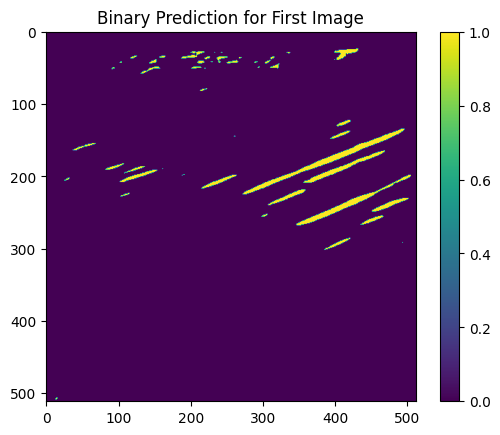

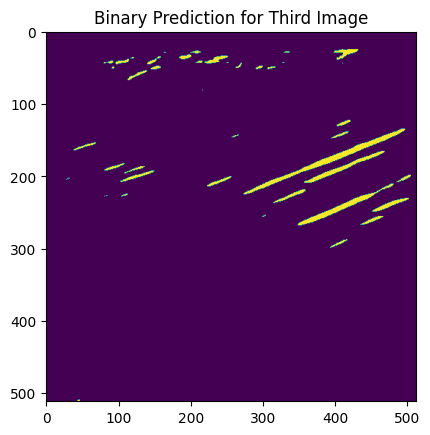

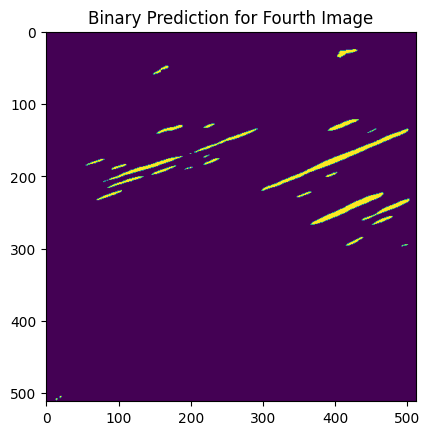

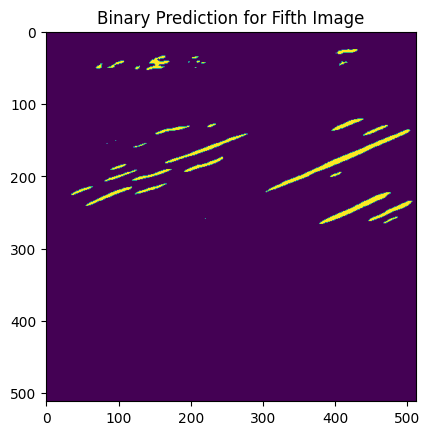

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the predictions are in the range [0, 1], not [0, 255]
predictions = np.array(predictions)

# Apply threshold for binary prediction (0.5 is typical for probabilities in range [0, 1])
threshold = 0.3
predictions_thresh = (predictions > threshold).astype(np.float32)

# Print the shape of the binary predictions
print(predictions_thresh.shape)

# Visualize the first prediction (binary mask)
im = plt.imshow(predictions_thresh[0, :, :, 0], cmap='viridis')
plt.colorbar(im)
plt.title("Binary Prediction for First Image")
plt.show()

# Visualize the second prediction (binary mask)
plt.imshow(predictions_thresh[1, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Third Image")
plt.show()

plt.imshow(predictions_thresh[24, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Fourth Image")
plt.show()

plt.imshow(predictions_thresh[42, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Fifth Image")
plt.show()




## Create video to check flow

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob

# Assuming predictions is already defined
predictions = np.array(predictions)

# Apply threshold for binary prediction (0.5 is typical for probabilities in range [0, 1])
threshold = 0.6
predictions_thresh = (predictions > threshold).astype(np.float32)

# Print the shape of the binary predictions
print(predictions_thresh.shape)

# Create a directory to save the frames
os.makedirs('frames', exist_ok=True)

# Save each frame as an image
for i in range(predictions_thresh.shape[0]):
    plt.imshow(predictions_thresh[i, :, :, 0], cmap='viridis')
    plt.title(f"Binary Prediction for Image {i+1}")
    plt.axis('off')
    plt.savefig(f'frames/frame_{i:04d}.png', bbox_inches='tight')
    plt.close()

# Get the list of frames
frame_files = sorted(glob.glob('frames/frame_*.png'))

# Read the first frame to get the dimensions
frame = cv2.imread(frame_files[0])
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 file
video = cv2.VideoWriter('predictions_video.mp4', fourcc, 60, (width, height))  # 1 FPS

# Write each frame to the video
for frame_file in frame_files:
    frame = cv2.imread(frame_file)
    video.write(frame)

# Release the video writer
video.release()

print("Video saved as predictions_video.mp4")

(565, 512, 512, 2)
Video saved as predictions_video.mp4
